# Learning Material Guidance:
- Hugging Face. https://huggingface.co/docs/transformers/model_doc/bert
- Similar Example:https://chriskhanhtran.github.io/_posts/2019-12-25-bert-for-sentiment-analysis/
- BERT Fine-Tuning Tutorial with PyTorch. https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification
- tqdm progress bar: https://zhuanlan.zhihu.com/p/163613814

# Exploratory Data Analysis & Data Preprocessing
- Dataset:https://figshare.com/articles/dataset/smile_annotations_final_csv/3187909/2
   - Contains 3085 tweets, 5 emotions named anger, disgust, happiness, surprise, sadness and the 6th label being not-relevant.

In [3]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#import python package we use
import torch
import pandas as pd
from tqdm.notebook import tqdm #a process bar

In [5]:
#import dataset
content=pd.read_csv('/content/smileannotationsfinal.csv',names=['id', 'text', 'category'])

In [6]:
content.head()

,id,text,category
0,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
1,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
2,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
3,614877582664835073,@Sofabsports thank you for following me back. ...,happy
4,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [7]:
#making the index for looking up to required data
content.set_index('id',inplace=True)

In [8]:
content.head()

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [9]:
#count grouping by the category value
content.category.value_counts()

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: category, dtype: int64

In [10]:
#remove the labels with "|" or "\"
content=content[~content.category.str.contains('\|')] #~:which is not include

In [11]:
#select ids which are not nocode category
content=content[content.category !='nocode'] 

In [12]:
#checkout the after filtering group counting
content.category.value_counts()

happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: category, dtype: int64

In [13]:
#change the label into dictionary
#return the unique values of series by order,put labels into a variable called possibleLabels
possibleLabels=content.category.unique()

In [14]:
#set up a label dictionary
labelDict={}
for index,possibleLabels in enumerate(possibleLabels):
  labelDict[possibleLabels]=index

In [15]:
#sort it in a new column called 'label',replace label by number
content['label']=content.category.replace(labelDict)

In [16]:
content.head()

,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Distribution(count)')

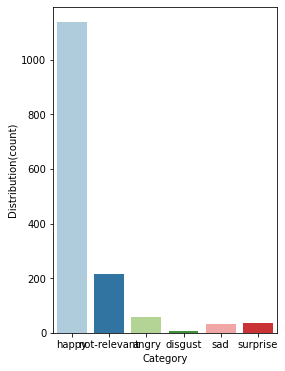

In [17]:
#look at the category distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(4,6))
sns.countplot(content.category,
              palette='Paired')
plt.xlabel('Category')
plt.ylabel('Distribution(count)')

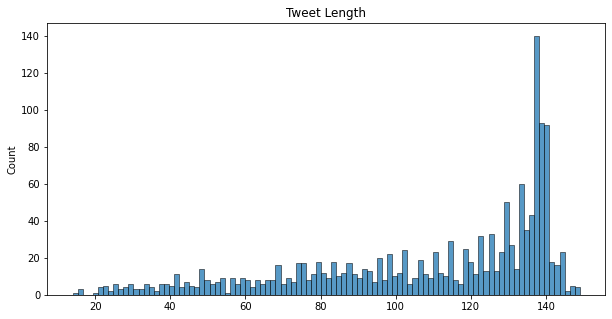

In [18]:
#visualize the tweet length
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in content.text], 
             bins=100)
plt.title('Tweet Length')
plt.show()

# Training/Validation Split

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train,X_val,y_train,y_val=train_test_split(content.index.values,
                                             content.label.values,
                                             test_size=0.15,
                                             random_state=17,
                                             stratify=content.label.values)

In [21]:
#give the name of datatype
content['data_type'] = ['not_set']*content.shape[0] #first fill in with not_set temporarily
#fill the datatype with train/val
content.loc[X_train,'data_type']='train'
content.loc[X_val,'data_type']='val'
#group by and count
content.groupby(['category','label','data_type']).count()

text
category     label data_type      
angry        2     train        48
                   val           9
disgust      3     train         5
                   val           1
happy        0     train       966
                   val         171
not-relevant 1     train       182
                   val          32
sad          4     train        27
                   val           5
surprise     5     train        30
                   val           5

# Loading the Tokenizer

In [22]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
pip install transformers[torch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
from transformers import BertTokenizer

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',  #instantiate a pre-trained model from a pre-trained model configuration.
                                          do_lower_case=True)   #lowercases the input.

# Encoding the Data

In [26]:
#encode training dataset
#reference:https://huggingface.co/docs/transformers/v4.23.1/en/main_classes/tokenizer#transformers.PreTrainedTokenizer
encoded_data_train=tokenizer.batch_encode_plus(
    content[content.data_type=='train'].text.values,      #specify the train set
    add_special_tokens=True, #adds the special [CLS] and [SEP] tokens to the beginning and the end of the sentences, respectively.
    return_attention_mask=True, #creates attention mask by creating array of 0s (pad token) and 1s (real token).
    pad_to_max_length=True, #creates constant length for all sequences by padding to max length.
    max_length=256,
    return_tensors='pt' #returns PyTorch tensor
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [27]:
#encode validation dataset
encoded_data_val=tokenizer.batch_encode_plus(
    content[content.data_type=='val'].text.values,
    add_special_tokens = True,
    return_attention_mask = True,
    pad_to_max_length = True,
    max_length = 256,
    return_tensors = 'pt'
)

In [28]:
encoded_data_train

{'input_ids': tensor([[  101, 16092,  3897,  ...,     0,     0,     0],
        [  101,  1030, 27034,  ...,     0,     0,     0],
        [  101,  1030, 10682,  ...,     0,     0,     0],
        ...,
        [  101, 11047,  1030,  ...,     0,     0,     0],
        [  101,  1030,  3680,  ...,     0,     0,     0],
        [  101,  1030,  2120,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [29]:
#Encoding:encoded_data_train and encoded_data_val are encoded train set and encoded val set
#train set
input_ids_train=encoded_data_train['input_ids'] #input_ids: List of token ids to be fed to a model.
attention_masks_train=encoded_data_train['attention_mask'] #attention_mask:List of indices specifying which tokens should be attended to by the model
labels_train = torch.tensor(content[content.data_type =='train'].label.values) #convert labels to tensor

In [30]:
#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(content[content.data_type == 'val'].label.values)

# Build the BERT Model

In [31]:
#Set up the Pre-trained Model
#references:https://huggingface.co/docs/transformers/v4.23.1/en/main_classes/model#transformers.PreTrainedModel.from_pretrained
#https://huggingface.co/docs/transformers/v4.23.1/en/model_doc/bert#transformers.BertForSequenceClassification
from transformers import BertForSequenceClassification
Bert=BertForSequenceClassification.from_pretrained('bert-base-uncased', #the specific model path/name
                                                   num_labels=len(labelDict), #number of category
                                                   output_attentions=False, # Whether or not to return the attentions tensors of all attention layers
                                                   output_hidden_states=False #Whether or not to return the hidden states of all layers
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [32]:
#model summary
Bert.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [33]:
#Create dataloader: provides a way to create a dataset out of the data,accepting data in numpy array and tensor form.
from torch.utils.data import TensorDataset

dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [34]:
#To speed up the training process, make an iterator over datasets 
#reference:https://pytorch.org/docs/stable/data.html
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
dataloader_train = DataLoader(dataset_train, #specify the dataset
                              sampler = RandomSampler(dataset_train), 
                              batch_size = 32) #since we have limited resource for computation
dataloader_val = DataLoader(dataset_val,
                            sampler = RandomSampler(dataset_val), #returns random indices
                            batch_size = 32) 


# Set up Optimizer and Scheduler

In [35]:
#AdamW optimizer, references:https://huggingface.co/docs/transformers/v4.23.1/en/main_classes/optimizer_schedules#transformers.AdamW
from transformers import AdamW, get_linear_schedule_with_warmup
Optimizer=AdamW(Bert.parameters(),
                lr=1e-5,       #The learning rate to use
                eps=1e-8)      #Adam’s epsilon for numerical stability.default is 1e-6


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [36]:
#reference:https://huggingface.co/docs/transformers/v4.23.1/en/main_classes/optimizer_schedules#transformers.get_linear_schedule_with_warmup
scheduler =get_linear_schedule_with_warmup(Optimizer,  #scheduler:gets called every time a batch is fed to the model.
                                          num_warmup_steps=0, #The number of steps for the warmup phase.
                                          num_training_steps=len(dataloader_train)*5) #set epochs=5,The total number of training steps.

- Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0.

- After a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.

# Define Performance Metrics
- Define the evaluation function
- Define f1-score
- Define accuracy_per_category function

In [37]:
import numpy as np
from sklearn.metrics import f1_score

In [38]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()  #argmax:applied over the features, returns indices of predictions (a number between 0-5) which gives classes.
    labels_flat = labels.flatten() #flattens prediction by reshaping it into a one-dimensional tensor.
    return f1_score(labels_flat, preds, average = 'weighted')

In [39]:
def accuracy_per_category(preds, labels):
    label_dict_inverse = {v: k for k, v in labelDict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')


In [40]:
#define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#As deep learning can be accellerated a lot using a GPU instead of a CPU,
#make sure you can run this notebook in a GPU runtime (which Google Colab provides for free! - check "Runtime" - "Change runtime type" - and set the hardware accelerator to "GPU").
def evaluate(dataloader_val):

    #evaluation model put it in validation mode by eval() and deactivates Dropout layer
    Bert.eval()
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        #unpacks DataLoader into GPU.
        batch = tuple(b.to(device) for b in batch) #https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch.Tensor.to
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}
        #compute logits
        with torch.no_grad():        
            outputs = Bert(**inputs)
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Train Model

In [41]:
import random
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
epochs=5
for epoch in tqdm(range(1, epochs+1)): 
    #train the Bert model
    Bert.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train,    #use tqdm to track progress
                        desc = 'Epoch {:1d}'.format(epoch),  #descriptive words
                        leave = False,       #value of bool, whether keep the progress bar or not
                        disable = False)
    for batch in progress_bar:
        Bert.zero_grad() #set gradient to 0
        batch = tuple(b.to(device) for b in batch) #to(device):unpacks data from the DataLoader and load the data to GPU.
        inputs = {'input_ids': batch[0],         #the inputs are divided into three parts
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        outputs = Bert(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward() #performs backward pass to compute gradients.
        
        torch.nn.utils.clip_grad_norm_(Bert.parameters(), 1.0) #clips the norm of the gradients to 1.0 to prevent exploding gradients.
        
        Optimizer.step() #updates the model’s parameters.
        scheduler.step() #updates learning rate.
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
    torch.save(Bert.state_dict(), f'BERT_ft_epoch{epoch}.Bert')
    tqdm.write('\n Epoch {epoch}')
    
    loss_train_avg = loss_train_total / len(dataloader)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

# Model Evaluation

In [ ]:
#save model
Bert.to(device)
pass

In [ ]:
#use dataloader_val to evaluate data
_,predictions,true_vals=evaluate(dataloader_val)

In [ ]:
#checkout predicted labels and accuracy score
accuracy_per_category(predictions, true_vals)